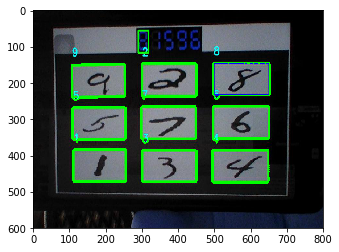

In [471]:
# Load Neccessary Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import caffe
from copy import deepcopy

def show(img_obj):
    plt.imshow(img_obj)
    plt.show()

# test2.jpg 是 test1.jpg 被我用画图工具把 7 手动连到底边得到的，其他没变

def get_size(cv2_img):
    height = len(cv2_img)
    width = len(cv2_img[0])
    return (width, height)

def swap(a,b):
    return b,a

def sort_points(rect):
    x_sort = np.array(sorted(rect, key=lambda x: x[1]))
    if x_sort[0,0] > x_sort[1,0]:
        x_sort[0,0], x_sort[1,0] = swap(x_sort[0,0], x_sort[1,0])
    if x_sort[2,0] > x_sort[3,0]:
        x_sort[2,0], x_sort[3,0] = swap(x_sort[2,0], x_sort[3,0])
    return x_sort

img = cv2.imread('./red.jpg')
img = cv2.resize(img, (800,600))
img_ori = img.copy()
img_cp = img.copy()
img_cp2 = img.copy()
img_cp3 = img.copy()
img_cp4 = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret3,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# Filter out contours that are either too big or too small
contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= 100*50 and cv2.contourArea(cnt) <= 180*90]
cv2.drawContours(img_cp3, contours, -1, (0,255,0), 3)
show(img_cp3)

9


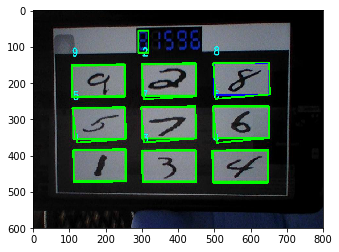

In [472]:
# First Approach: adjusting epsilon
# 似乎并不行 —— 理论上来说矫正需要矫正 Epsilon 来使 Ramer–Douglas–Peucker 算法的误差增加，但是同时会影响到正常 approx。
# Epsilon = 0.05%
tmp = []
for cnt in contours:
    epsilon = 0.05*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    if len(approx) == 4 and cv2.isContourConvex(approx):
        tmp.append(approx)
print len(tmp)
contours1 = np.array(tmp)[:,:,0,:]
cv2.drawContours(img_cp, contours1, -1, (0,255,0), 3)
show(img_cp)

[[494 475]
 [494 384]
 [650 384]
 [650 475]]
494
650
384
475


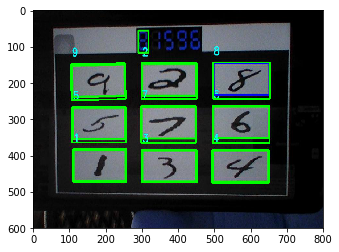

In [473]:
#Second Approach: Bounding Rect
tmp = []
for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_cp4,[box],0,(0,255,0),3)
    tmp.append(box)

print tmp[0]
print min(tmp[0], key = lambda x: x[0])[0]
print max(tmp[0], key = lambda x: x[0])[0]
print min(tmp[0], key = lambda x: x[1])[1]
print max(tmp[0], key = lambda x: x[1])[1]
show(img_cp4)

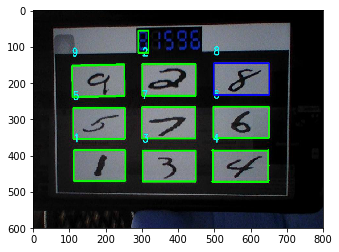

In [474]:
#Third Approach: Convex Hull
now_img = img_ori.copy()
hull = cv2.convexHull(contours[0])
cv2.drawContours(now_img, hull, -1,(0,255,0),3)
show(now_img)

[array([[494, 384],
       [650, 384],
       [650, 475],
       [494, 475]], dtype=int32), array([[300, 384],
       [451, 384],
       [451, 474],
       [300, 474]], dtype=int32), array([[110, 382],
       [256, 382],
       [256, 473],
       [110, 473]], dtype=int32), array([[108, 266],
       [255, 266],
       [255, 364],
       [108, 364]], dtype=int32), array([[298, 264],
       [450, 264],
       [450, 365],
       [298, 365]], dtype=int32), array([[495, 263],
       [652, 263],
       [652, 365],
       [495, 365]], dtype=int32), array([[106, 147],
       [254, 147],
       [254, 248],
       [106, 248]], dtype=int32), array([[299, 146],
       [451, 146],
       [451, 245],
       [299, 245]], dtype=int32), array([[497, 144],
       [653, 144],
       [653, 244],
       [497, 244]], dtype=int32)]


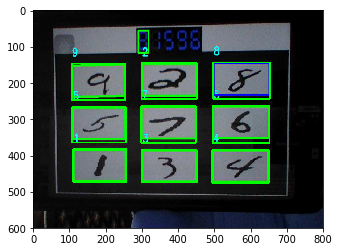

In [475]:
#Fourth Approach: bounding rect contours
now_img = img_ori.copy()
tmp = deepcopy(contours)

def find_contour_bound(cont):
    left_bound = min(cont, key = lambda x: x[0])[0]
    right_bound = max(cont, key = lambda x: x[0])[0]
    lower_bound = min(cont, key = lambda x: x[1])[1]
    upper_bound = max(cont, key = lambda x: x[1])[1]
    return (left_bound, right_bound, lower_bound, upper_bound)

boxes = []
for cnt in tmp:
    left, right, lower, upper = find_contour_bound(cnt[:,0])
    box = np.array([[left, lower], [right, lower], [right, upper], [left, upper]])
    boxes.append(box)
    cv2.drawContours(now_img, [box], -1,(0,255,0),3)

print boxes
show(now_img)

In [476]:
#Fifth Approach: Morphological Closing
# 找出 contours 之后，处理成内 1 外 0 的灰度 numpy，再根据矩形宽度（max(x) - min(x)）得到 kernel，做 closing 后再还原成 contours 再 Approx。
new_img = img_ori.copy()

#Approx contour with a rect that 
def contour_2_gray(contour_array):
    pass

# Must be closed
def gray_2_contour(gray_np_array):
    pass

tmp = deepcopy(contours)
#contours1 = np.array(tmp)[:,:,0,:]
print len(tmp)
print cv2.pointPolygonTest(tmp[0], (300, 450), False)

9
-1.0


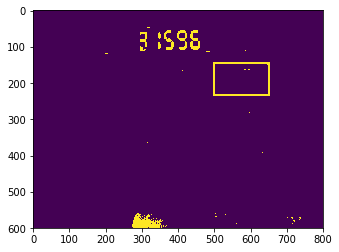

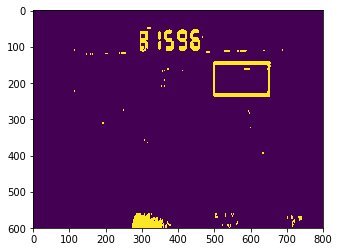

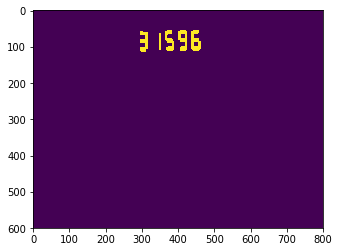

In [477]:
#7-SSD Detection
org_img = img_ori.copy()
tmp = []
for cnt in contours:
    epsilon = 0.05*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    if len(approx) == 4 and cv2.isContourConvex(approx):
        tmp.append(approx)

#if len(tmp) == 0:
#    return img

contours = np.array(tmp)[:,:,0,:]
BOX_LEN = 32                # bounding box length for digits
offset = (BOX_LEN - 28) / 2 # calculated padding length
# Destination Points
dstpts = np.array([[0,0],[BOX_LEN,0],[0,BOX_LEN],[BOX_LEN,BOX_LEN]], dtype='float32')
bboxs = []
points = []

for cnt in contours:
    # Sort points with respect to relative location
    pts1 = sort_points(cnt).astype('float32')
    points.append(pts1)
    # Geometric transformation that project the 4-sided shape onto a 32x32 grid
    M = cv2.getPerspectiveTransform(pts1,dstpts)
    new_img = cv2.warpPerspective(gray,M,(BOX_LEN,BOX_LEN))
    new_img = 255 - new_img[offset:-offset, offset:-offset]
    bboxs.append(new_img)

hsv_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV)
lower_red = np.array([0,90,70])
upper_red = np.array([15,255,255])
mask = cv2.inRange(hsv_img, lower_red, upper_red)
mask1 = cv2.inRange(hsv_img, lower_red, upper_red)
lower_red = np.array([155,90,70])
upper_red = np.array([179,255,255])
mask2 = cv2.inRange(hsv_img, lower_red, upper_red)
mask = np.bitwise_or(mask1, mask2)
show(mask)

#dilation
kernel = np.ones((5, 2), np.uint8)
mask = cv2.dilate(mask, kernel, iterations = 1)
show(mask)

kernel1 = np.ones((9,9),np.uint8)
kernel2 = np.ones((6,6),np.uint8)
kernel3 = np.ones((5,6),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel2)

y_min = min(points,key=lambda cnt: cnt[0,1])[0,1]
y_min = int(y_min)
x_min1 = min(points, key=lambda cnt: cnt[1,0])[1,0]
x_min1 = int(x_min1)
x_min2 = max(points, key=lambda cnt: cnt[0,0])[0,0]
x_min2 = int(x_min2)
ftr = np.ones(img.shape[0:2],np.uint8)
ftr[y_min:-1,:] = 0
ftr[:,0:x_min1] = 0
ftr[:,x_min2:] = 0
mask = cv2.bitwise_and(mask, mask, mask=ftr)
show(mask)